# Monetary Economics: Chapter 9

### Preliminaries

In [1]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline

from pysolve.model import Model
from pysolve.utils import is_close,round_solution

import matplotlib.pyplot as plt

### Model DIS

In [2]:
def create_dis_model():
    model = Model()

    model.set_var_default(0)
    model.var('Ck', desc='REal consumption')
    model.var('C', desc='Consumption at current prices')
    model.var('F', desc='Realized firm profits')
    model.var('Fb', desc='Realized bank profits')
    model.var('IN', desc='Stock of inventories at current costs')
    model.var('INk', desc='Real inventories')
    model.var('INke', desc='Expected real inventories')
    model.var('INkt', desc='Target level of real inventories')
    model.var('Ld', desc='Demand for loans')
    model.var('Ls', desc='Supply of loans')
    model.var('Mh', desc='Deposits held by households')
    model.var('Mhk', desc='Real alue of deposits held by households')
    model.var('Ms', desc='Supply of deposits')
    model.var('N', desc='Employment level')
    model.var('NHUC', desc='Normal historic unit costs')
    model.var('P', desc='Price level')
    model.var('Rl', desc='Interest rate on loans')
    model.var('Rm', desc='Interest rate on deposits')
    model.var('S', desc='Sales at current prices')
    model.var('Sk', desc='Real sales')
    model.var('Ske', desc='Expected real sales')
    model.var('UC', desc='Unit costs')
    model.var('WB', desc='The wage bill')
    model.var('Yk', desc='Real output')
    model.var('YD', desc='Disposable income')
    model.var('YDkhs', desc='Haig-Simons measure of real disposable income')
    model.var('YDkhse', desc='Expected HS real disposable income')
    
    model.set_param_default(0)
    model.param('alpha0', desc='Autonomous consumption')
    model.param('alpha1', desc='Propensity to consume out of income')
    model.param('alpha2', desc='Propensity to consume out of wealth')
    model.param('beta', desc='Parameter in expectation formations on real sales')
    model.param('eps', desc='Parameter in expectation formations on real disposable income')
    model.param('gamma', desc='Speed of adjustment of inventories to the target level')
    model.param('phi', desc='Mark-up on unit costs')
    model.param('sigmat', desc='Target inventories to sales ratio')

    model.param('ADD', desc='Spread of loans rate over the deposit rate')
    model.param('PR', desc='Labor productivity')
    model.param('Rlbar', desc='Rate of interest on bank loans, set exogenously')
    model.param('W', desc='Wage rate')


    # The production decision
    model.add('Yk = Ske + INke - INk(-1)')
    model.add('INkt = sigmat*Ske')
    model.add('INke = INk(-1) + gamma*(INkt - INk(-1))')
    model.add('INk - INk(-1) = Yk - Sk')
    model.add('Ske = beta*Sk(-1) + (1-beta)*Ske(-1)')
    model.add('Sk = Ck')
    model.add('N = Yk / PR')
    model.add('WB = N*W')
    model.add('UC = WB/Yk')
    model.add('IN = INk*UC')
    
    # The pricing decision
    model.add('S = P*Sk')
    model.add('P = (1 + phi)*NHUC')
    model.add('NHUC = (1 - sigmat)*UC + sigmat*(1 + Rl(-1))*UC(-1)')
    model.add('F = S - WB + IN - IN(-1) - Rl(-1)*IN(-1)')
    
    # The banking system
    model.add('Ld = IN')
    model.add('Ls = Ld')
    model.add('Ms = Ls')
    model.add('Rl = Rlbar')
    model.add('Rm = Rl - ADD')
    model.add('Fb = Rl(-1)*Ld(-1) - Rm(-1)*Mh(-1)')
    
    # The consumption decision
    model.add('YD = WB + F + Fb + Rm(-1)*Mh(-1)')
    model.add('Mh - Mh(-1) = YD - C')
    model.add('YDkhs = Ck + (Mhk - Mhk(-1))')
    model.add('C = Ck*P')
    model.add('Mhk = Mh/P')
    model.add('Ck = alpha0 + alpha1*YDkhse + alpha2*Mhk(-1)')
    model.add('YDkhse = eps*YDkhs(-1) + (1 - eps)*YDkhse(-1)')
    return model

dis_parameters = {'alpha0': 15,
                  'alpha1': 0.8,
                  'alpha2': 0.1,
                  'beta': 0.75,
                  'eps': 0.75,
                  'gamma': 0.25,
                  'phi': 0.25,
                  'sigmat': 0.15}
dis_exogenous = {'ADD': 0.02,
                 'PR': 1,
                 'Rlbar': 0.04,
                 'W': 0.86}

# Warning! If you wish to initialize the variables using equations.
# the order in which they appear is important.  Ordinary Python
# dictionaries are not ordered, so the values will be incorrect,
# use a list of (name, equation) tuples or an OrderedDict()
#
dis_variables = [('UC', 'W/PR'),
                 ('NHUC', '(1 + sigmat*Rlbar)*UC'),
                 ('P', '(1+phi)*NHUC'),
                 ('YDkhs', 'alpha0/(1-alpha1-alpha2*sigmat*UC/P)'),
                 ('Ck', 'YDkhs'),
                 ('Sk', 'Ck'),
                 ('INk', 'sigmat*Sk'),
                 ('IN', 'INk*UC'),
                 ('Ld', 'IN'),
                 ('Mh', 'Ld'),
                 ('Mhk', 'Mh/P'),
                 ('Ms', 'Mh'),
                 ('Ls', 'Ld'),
                 ('Ske', 'Sk'),
                 ('YDkhse', 'YDkhs'),
                 ('Rl', 'Rlbar'),
                 ('Rm', 'Rl - ADD')]


### Scenario: Model DIS, increase in the mark-up

In [3]:
phi = create_dis_model()
phi.set_values(dis_parameters)
phi.set_values(dis_exogenous)
phi.set_values(dis_variables)

# run to convergence
# Give the system more time to reach a steady state
for _ in range(15):
    phi.solve(iterations=200, threshold=1e-6)

# shock the system
phi.set_values({'phi': 0.3})

for _ in range(40):
    phi.solve(iterations=100, threshold=1e-6)

###### Figure 9.1

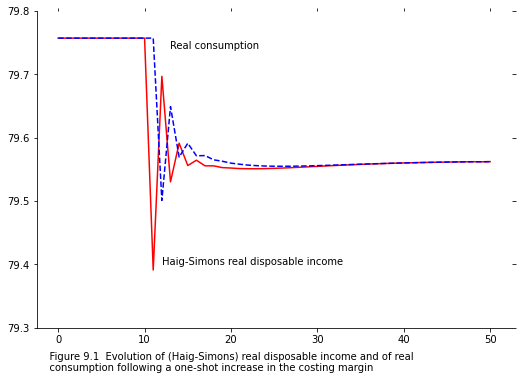

In [4]:
caption = '''
    Figure 9.1  Evolution of (Haig-Simons) real disposable income and of real
    consumption following a one-shot increase in the costing margin'''
ydkhsdata = [s['YDkhs'] for s in phi.solutions[5:]]
ckdata = [s['Ck'] for s in phi.solutions[5:]]

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1.1, 1.1])
axes.tick_params(top='off', right='off')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_ylim(79.3, 79.8)

axes.plot(ydkhsdata, linestyle='-', color='r')
axes.plot(ckdata, linestyle='--', color='b')

# add labels
plt.text(13, 79.74, 'Real consumption')
plt.text(12, 79.4, 'Haig-Simons real disposable income')
fig.text(0.1, -.05, caption);

### Scenario: Model DIS, Increase in the propensity to save out of disposable income

In [5]:
sigmat = create_dis_model()
sigmat.set_values(dis_parameters)
sigmat.set_values(dis_exogenous)
sigmat.set_values(dis_variables)

# run to convergence
# Give the system more time to reach a steady state
for _ in range(15):
    sigmat.solve(iterations=200, threshold=1e-6)

# shock the system
sigmat.set_values({'sigmat': 0.25})

for _ in range(40):
    sigmat.solve(iterations=100, threshold=1e-6)

###### Figure 9.2

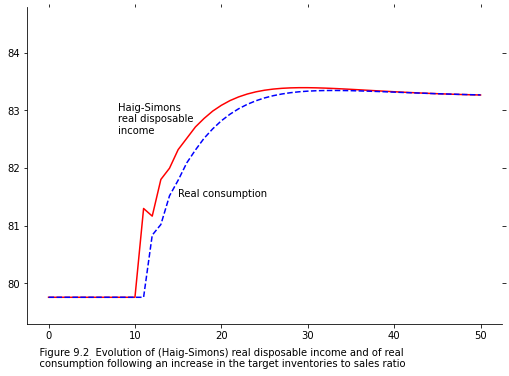

In [6]:
caption = '''
    Figure 9.2  Evolution of (Haig-Simons) real disposable income and of real
    consumption following an increase in the target inventories to sales ratio'''
ydkhsdata = [s['YDkhs'] for s in sigmat.solutions[5:]]
ckdata = [s['Ck'] for s in sigmat.solutions[5:]]

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1.1, 1.1])
axes.tick_params(top='off', right='off')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_ylim(79.3, 84.8)

axes.plot(ydkhsdata, linestyle='-', color='r')
axes.plot(ckdata, linestyle='--', color='b')

# add labels
plt.text(15, 81.5, 'Real consumption')
plt.text(8, 83, 'Haig-Simons')
plt.text(8, 82.8, 'real disposable')
plt.text(8, 82.6, 'income')
fig.text(0.1, -.05, caption);

###### Figure 9.3

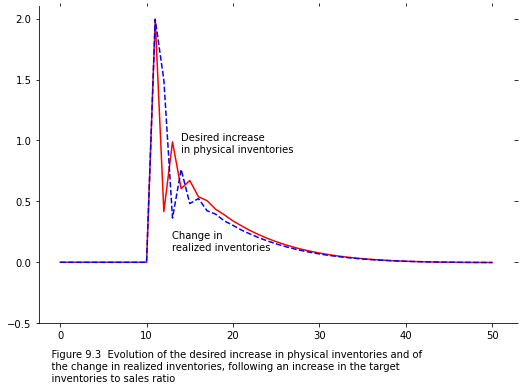

In [7]:
caption = '''
    Figure 9.3  Evolution of the desired increase in physical inventories and of
    the change in realized inventories, following an increase in the target
    inventories to sales ratio'''
inkdata = list()
inkedata = list()

for i in range(5, len(sigmat.solutions)):
    s = sigmat.solutions[i]
    s_1 = sigmat.solutions[i-1]
    
    # to get the shape of the graph in the book,
    # use INkt - INk
    inkdata.append(s['INk'] - s_1['INk'])
    inkedata.append(s['INke'] - s_1['INke'])

fig = plt.figure()
axes = fig.add_axes([0.1, 0.1, 1.1, 1.1])
axes.tick_params(top='off', right='off')
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_ylim(-0.5, 2.1)

axes.plot(inkdata, linestyle='-', color='r')
axes.plot(inkedata, linestyle='--', color='b')

# add labels
plt.text(13, 0.2, 'Change in')
plt.text(13, 0.1, 'realized inventories')
plt.text(14, 1.0, 'Desired increase')
plt.text(14, 0.9, 'in physical inventories')
fig.text(0.1, -.1, caption);